In [ ]:
from pathlib import Path
import os
import pickle
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import rankdata, spearmanr

In [ ]:
# Adjust paths as needed
RESULTS = Path("./shap_results_mom_bocd").resolve()

# original training data (to recover OOS feature values)
LTR_HDF_PATH = Path("features/ltr_df.h5")
LTR_HDF_KEY  = "ltr_df"

#  feature list (must match the model)
FEATURE_COLS = [
    'sigma_lag_span_63_z',
    
    # _z refers to winsorizing, then z-scoring (subtract mean return and divide by std of that day)
    # short & medium momentum/m
    '21_day_raw_ret_z',
    '63_day_raw_ret_z',

    # long momentum
    '252_day_raw_ret_z',

    # vol-and-time-adj the above
    '21_day_vol_time_scaled_ret_z',
    '63_day_vol_time_scaled_ret_z',
    '252_day_vol_time_scaled_ret_z',

    # (252, 42)_day_raw_ret are 
    '(252, 42)_day_raw_ret_z',
    '(252, 42)_day_vol_time_scaled_ret_z',

    # MACD(S, L) as per Daniel's papers
    '8_24_curr_z',
    '16_48_curr_z',
    '32_96_curr_z',

    '8_24_lag_1m_z',
    '16_48_lag_1m_z',
    '32_96_lag_1m_z',
    
    
    '8_24_lag_3m_z',
    '16_48_lag_3m_z',
    '32_96_lag_3m_z',
    
    '8_24_lag_6m_z',
    '16_48_lag_6m_z',
    '32_96_lag_6m_z',
    
    '8_24_lag_12m_z',
    '16_48_lag_12m_z',
    '32_96_lag_12m_z',

    # BOCD
    'p_t',
    'E_rt',
    'dE_rt',
    'Pr_le_5',
    'Pr_le_10',
    'Pr_le_14',
    'Pr_le_21',
    'Pr_le_42',
    'Pr_le_63',
    'Pr_le_126',
    'Pr_le_252',
    'H_rt',
    'Var_rt',
    'r_med',
    'p_t_z',
    'E_rt_z',
    'dE_rt_z',
    'Pr_le_5_z',
    'Pr_le_10_z',
    'Pr_le_14_z',
    'Pr_le_21_z',
    'Pr_le_42_z',
    'Pr_le_63_z',
    'Pr_le_126_z',
    'Pr_le_252_z',
    'H_rt_z',
    'Var_rt_z',
    'r_med_z',
]


TRAIN_TEST_LSTS = [
    [("1999-01-01", "2004-11-25"), ("2004-12-01", "2009-11-30")],
    [("1999-01-01", "2009-11-25"), ("2009-12-01", "2014-11-30")],
    [("1999-01-01", "2014-11-25"), ("2014-12-01", "2019-11-30")],
    [("1999-01-01", "2019-11-25"), ("2019-12-01", "2024-12-31")],
]
WIN_LABELS = ["win0_cfgN", "win1_cfgO", "win2_cfgO", "win3_cfgO"]

RET_COL = "fwd_ret_div_sigma_lag_63"

# Toggle: also compute correlations vs the continuous target
ALSO_CORR_VS_RET = True

pd.options.display.float_format = "{:,.6f}".format


In [ ]:
def load_window_artifacts(win_label: str):
    """Load proba + meta (dates, features) for a window from RESULTS/<win_label>/."""
    out_dir = RESULTS / win_label
    assert out_dir.exists(), f"Missing dir: {out_dir}"

    proba = np.load(out_dir / "proba.npy", allow_pickle=False)  # (n,3)
    with open(out_dir / "meta.pkl", "rb") as f:
        meta = pickle.load(f)

    dates_pred = pd.to_datetime(meta["dates"])  # exactly what was used when predicting OOS
    feats = meta.get("features", FEATURE_COLS)
    return {"out_dir": out_dir, "proba": proba, "dates": dates_pred, "features": feats}

def get_oos_slice(df: pd.DataFrame, test_span):
    """Return OOS rows (inclusive) in the same order as df."""
    d0 = pd.to_datetime(test_span[0]).date()
    d1 = pd.to_datetime(test_span[1]).date()
    te = df.loc[(df["date"] >= d0) & (df["date"] <= d1)].reset_index(drop=True)
    return te

def net_score_from_proba(P: np.ndarray) -> np.ndarray:
    """P is (n,3). Returns net_score = P2 - P0."""
    return P[:, 2] - P[:, 0]

def date_balanced_spearman(x: np.ndarray, y: np.ndarray, dates: pd.Series) -> tuple[float, pd.Series]:
    """
    Per-date Spearman (skip dates with <2 unique values), then average (nanmean).
    Returns (mean_spearman, per_date_series).
    """
    from scipy.stats import spearmanr
    df = pd.DataFrame({"date": pd.to_datetime(dates), "x": x, "y": y})
    vals, idx = [], []
    for t, g in df.groupby("date", sort=False):
        gx, gy = g["x"], g["y"]
        m = gx.notna() & gy.notna()
        gx, gy = gx[m], gy[m]
        if len(gx) < 3 or gx.nunique() < 2 or gy.nunique() < 2:
            vals.append(np.nan); idx.append(t); continue
        vals.append(spearmanr(gx, gy).correlation)
        idx.append(t)
    s = pd.Series(vals, index=pd.to_datetime(idx), name="spearman")
    return float(np.nanmean(s.values)), s

def _as_series_datetime(x) -> pd.Series:
    """Coerce Series/Index/array-like of datetimes into a normalized Series[datetime64[ns]]."""
    if isinstance(x, pd.Series):
        s = pd.to_datetime(x)
    elif isinstance(x, (pd.Index, pd.DatetimeIndex)):
        s = pd.to_datetime(pd.Series(x))
    else:
        s = pd.to_datetime(pd.Series(np.asarray(x)))
    return s.reset_index(drop=True)

def assert_alignment(dates_pred, dates_df):
    """
    Ensure the OOS slice ordering matches the prediction ordering used for proba.npy.
    Guards against accidental re-sorting.
    """
    a = _as_series_datetime(dates_pred)
    b = _as_series_datetime(dates_df)
    if len(a) != len(b):
        raise ValueError(f"Length mismatch: predictions (n={len(a)}) vs OOS slice (n={len(b)}).")
    if not np.array_equal(a.values, b.values):
        # minimal diagnostics (how many dates differ)
        diff_count = np.sum(a.values != b.values)
        raise ValueError(
            f"Row-order misalignment between predictions and OOS slice "
            f"(first {min(10, diff_count)} mismatches shown):\n"
            f"pred[:5]={a.head().tolist()} vs slice[:5]={b.head().tolist()}"
        )


In [ ]:
ltr_df = pd.read_hdf(LTR_HDF_PATH, key=LTR_HDF_KEY).copy()
ltr_df["date"] = pd.to_datetime(ltr_df["date"]).dt.date

need = set(["date", RET_COL] + FEATURE_COLS)
missing = need - set(ltr_df.columns)
assert not missing, f"Missing columns in ltr_df: {missing}"

print(f"ltr_df loaded: {len(ltr_df):,} rows | {min(ltr_df['date'])} → {max(ltr_df['date'])}")


ltr_df loaded: 6,771,765 rows | 1997-11-18 → 2024-11-29


In [ ]:
Z_FEATURE_COLS = [f for f in FEATURE_COLS if f.endswith("_z")]


CUTOFF = pd.Timestamp("2005-01-01")

FEATURES_FOR_CORR = Z_FEATURE_COLS

# Collect per-window arrays once, then concatenate
x_lists   = {f: [] for f in FEATURES_FOR_CORR}
net_list  = []
dates_list = []
if ALSO_CORR_VS_RET:
    y_list = []

for i, lbl in enumerate(WIN_LABELS):
    (_, test_span) = TRAIN_TEST_LSTS[i]
    art = load_window_artifacts(lbl)
    P   = art["proba"]
    dts_pred = art["dates"]

    # OOS slice to recover feature values & continuous target
    te = get_oos_slice(ltr_df, test_span)

    # row-alignment check
    assert_alignment(dts_pred, pd.to_datetime(te["date"]))

    # Arrays shared by all features in this window
    net   = net_score_from_proba(P).astype(float)     # (n,)
    dates = pd.to_datetime(te["date"])                # (n,)

    net_list.append(net)
    dates_list.append(dates.to_numpy())

    if ALSO_CORR_VS_RET:
        y_cont = te[RET_COL].astype(float).to_numpy()
        y_list.append(y_cont)

    # Per-feature arrays for this window
    for f in FEATURES_FOR_CORR:
        x_lists[f].append(te[f].astype(float).to_numpy())

# Concatenate across windows and apply cutoff
net_all   = np.concatenate(net_list)
dates_all = np.concatenate(dates_list)
mask      = pd.to_datetime(dates_all) >= CUTOFF

if ALSO_CORR_VS_RET:
    y_all = np.concatenate(y_list)

rows = []
for f, arrs in x_lists.items():
    x_all = np.concatenate(arrs)

    x_cut     = x_all[mask]
    net_cut   = net_all[mask]
    dates_cut = pd.to_datetime(dates_all[mask])

    sp_net_mean, _ = date_balanced_spearman(x_cut, net_cut, dates_cut)
    if ALSO_CORR_VS_RET:
        y_cut = y_all[mask]
        sp_ret_mean, _ = date_balanced_spearman(x_cut, y_cut, dates_cut)
    else:
        sp_ret_mean = np.nan

    rows.append({
        "feature": f,
        "spearman_db_feature_vs_net_overall": sp_net_mean,
        "spearman_db_feature_vs_ret_overall": sp_ret_mean,
        "start_date_included": CUTOFF.date(),
    })

df_overall = (
    pd.DataFrame(rows)
      .sort_values("spearman_db_feature_vs_net_overall", ascending=False, kind="mergesort")
      .reset_index(drop=True)
)
display(df_overall.head(10))

overall_csv = RESULTS / "feature_correlations_OVERALL_from_2005-01-01.csv"
df_overall.to_csv(overall_csv, index=False)
print(f"[saved] {overall_csv}")


,feature,spearman_db_feature_vs_net_overall,spearman_db_feature_vs_ret_overall,start_date_included
0,"(252, 42)_day_vol_time_scaled_ret_z",0.200572,0.017380,2005-01-01
1,32_96_lag_3m_z,0.198123,0.017547,2005-01-01
2,16_48_lag_3m_z,0.174040,0.012686,2005-01-01
3,32_96_lag_1m_z,0.166225,0.015904,2005-01-01
4,"(252, 42)_day_raw_ret_z",0.141743,0.008631,2005-01-01
5,16_48_lag_6m_z,0.134649,0.019048,2005-01-01
6,8_24_lag_6m_z,0.121396,0.011578,2005-01-01
7,32_96_lag_6m_z,0.105232,0.016606,2005-01-01
8,Var_rt_z,0.090188,0.006700,2005-01-01
9,E_rt_z,0.089266,0.009304,2005-01-01


[saved] C:\Users\benja\Desktop\oxford\Dissertation\cs_strats\shap_results_mom_bocd_exp_clean_mono_con\feature_correlations_OVERALL_from_2005-01-01.csv


In [17]:
num_agree = (np.sign(df_overall['spearman_db_feature_vs_net_overall']) == np.sign(df_overall['spearman_db_feature_vs_ret_overall'])).sum()
total_len = len(df_overall)
print(f"Num agree: {num_agree}")
print(f"total len: {total_len}")
print(f"Proportion: {num_agree / total_len}")
# (np.sign(df_overall['spearman_db_feature_vs_net_overall']) == np.sign(df_overall['spearman_db_feature_vs_ret_overall'])).sum() / len(df_overall)

Num agree: 34
total len: 38
Proportion: 0.8947368421052632


In [18]:
df_overall.sort_values(by='spearman_db_feature_vs_net_overall')

,feature,spearman_db_feature_vs_net_overall,spearman_db_feature_vs_ret_overall,start_date_included
37,sigma_lag_span_63_z,-0.478382,-0.052725,2005-01-01
36,21_day_raw_ret_z,-0.322988,-0.007764,2005-01-01
35,21_day_vol_time_scaled_ret_z,-0.313709,-0.006793,2005-01-01
34,8_24_curr_z,-0.276109,-0.003446,2005-01-01
33,63_day_raw_ret_z,-0.245556,-0.005154,2005-01-01
32,63_day_vol_time_scaled_ret_z,-0.224592,-0.000213,2005-01-01
31,8_24_lag_12m_z,-0.098943,0.003165,2005-01-01
30,16_48_lag_12m_z,-0.098290,0.008836,2005-01-01
29,Pr_le_252_z,-0.091678,-0.008794,2005-01-01
28,16_48_curr_z,-0.086716,0.008174,2005-01-01


In [ ]:
combined_rows = []

for i, lbl in enumerate(WIN_LABELS):
    (_, test_span) = TRAIN_TEST_LSTS[i]
    art = load_window_artifacts(lbl)
    P   = art["proba"]
    dts_pred = art["dates"]

    # OOS slice to recover feature values & continuous target
    te = get_oos_slice(ltr_df, test_span)

    # row-alignment check
    assert_alignment(dts_pred, pd.to_datetime(te["date"]))

    # Arrays
    net   = net_score_from_proba(P).astype(float)             
    dates = pd.to_datetime(te["date"])                        
    if ALSO_CORR_VS_RET:
        y_cont = te[RET_COL].astype(float).to_numpy()

    rows = []
    for f in Z_FEATURE_COLS:
        x = te[f].astype(float).to_numpy()

        # Date-balanced Spearman correlations
        sp_net_mean, _ = date_balanced_spearman(x, net, dates)
        if ALSO_CORR_VS_RET:
            sp_ret_mean, _ = date_balanced_spearman(x, y_cont, dates)
        else:
            sp_ret_mean = np.nan

        rows.append({
            "feature": f,
            "spearman_db_feature_vs_net": sp_net_mean,
            "spearman_db_feature_vs_ret": sp_ret_mean,
        })

    df_corr = (
        pd.DataFrame(rows)
          .sort_values("spearman_db_feature_vs_net", ascending=False, kind="mergesort")
          .reset_index(drop=True)
    )
    display(df_corr.head(10))

    out_csv = art["out_dir"] / f"{lbl}_feature_correlations.csv"
    df_corr.to_csv(out_csv, index=False)
    print(f"[saved] {out_csv}")

    df_corr2 = df_corr.copy()
    df_corr2.insert(0, "window", lbl)
    combined_rows.append(df_corr2)

# Combined CSV across windows
all_corr = pd.concat(combined_rows, ignore_index=True)
all_csv = RESULTS / "feature_correlations_all_windows.csv"
all_corr.to_csv(all_csv, index=False)
print(f"[saved] {all_csv}")


,feature,spearman_db_feature_vs_net,spearman_db_feature_vs_ret
0,"(252, 42)_day_vol_time_scaled_ret_z",0.150007,-0.002239
1,"(252, 42)_day_raw_ret_z",0.124217,-0.002834
2,32_96_lag_3m_z,0.120903,0.007513
3,16_48_lag_3m_z,0.113319,0.007539
4,r_med_z,0.098294,0.009661
5,E_rt_z,0.094400,0.013252
6,8_24_lag_6m_z,0.093130,0.009213
7,16_48_lag_6m_z,0.087676,0.005029
8,Var_rt_z,0.073623,0.001586
9,8_24_lag_3m_z,0.068919,0.005869


[saved] C:\Users\benja\Desktop\oxford\Dissertation\cs_strats\shap_results_mom_bocd_exp_clean_mono_con\win0_cfgN\win0_cfgN_feature_correlations.csv


,feature,spearman_db_feature_vs_net,spearman_db_feature_vs_ret
0,32_96_lag_3m_z,0.285919,0.022165
1,32_96_lag_1m_z,0.285688,0.017179
2,16_48_lag_3m_z,0.282432,0.012578
3,"(252, 42)_day_vol_time_scaled_ret_z",0.236298,0.030753
4,E_rt_z,0.195478,0.010384
5,Var_rt_z,0.185614,0.008790
6,8_24_lag_3m_z,0.185117,-0.003765
7,r_med_z,0.182741,0.006140
8,32_96_curr_z,0.173336,0.014413
9,16_48_lag_1m_z,0.172331,0.011646


[saved] C:\Users\benja\Desktop\oxford\Dissertation\cs_strats\shap_results_mom_bocd_exp_clean_mono_con\win1_cfgO\win1_cfgO_feature_correlations.csv


,feature,spearman_db_feature_vs_net,spearman_db_feature_vs_ret
0,"(252, 42)_day_vol_time_scaled_ret_z",0.321436,0.021010
1,32_96_lag_3m_z,0.289376,0.017987
2,"(252, 42)_day_raw_ret_z",0.263834,0.011502
3,32_96_lag_1m_z,0.252054,0.025415
4,16_48_lag_3m_z,0.232037,0.014920
5,252_day_vol_time_scaled_ret_z,0.230556,0.018315
6,16_48_lag_6m_z,0.224865,0.014838
7,32_96_lag_6m_z,0.205841,0.014267
8,8_24_lag_6m_z,0.181071,0.000987
9,252_day_raw_ret_z,0.173202,0.009909


[saved] C:\Users\benja\Desktop\oxford\Dissertation\cs_strats\shap_results_mom_bocd_exp_clean_mono_con\win2_cfgO\win2_cfgO_feature_correlations.csv


,feature,spearman_db_feature_vs_net,spearman_db_feature_vs_ret
0,H_rt_z,0.140285,0.024408
1,32_96_lag_3m_z,0.098134,0.023435
2,"(252, 42)_day_vol_time_scaled_ret_z",0.095944,0.020687
3,16_48_lag_3m_z,0.070655,0.016467
4,32_96_lag_1m_z,0.068367,0.009687
5,16_48_lag_6m_z,0.064142,0.029111
6,Pr_le_14_z,0.054593,-0.002857
7,Pr_le_21_z,0.054419,-0.003866
8,8_24_lag_6m_z,0.053916,0.028115
9,Pr_le_10_z,0.053407,-0.002864


[saved] C:\Users\benja\Desktop\oxford\Dissertation\cs_strats\shap_results_mom_bocd_exp_clean_mono_con\win3_cfgO\win3_cfgO_feature_correlations.csv
[saved] C:\Users\benja\Desktop\oxford\Dissertation\cs_strats\shap_results_mom_bocd_exp_clean_mono_con\feature_correlations_all_windows.csv


In [8]:
sign_net = np.sign(all_corr["spearman_db_feature_vs_net"])
sign_ret = np.sign(all_corr["spearman_db_feature_vs_ret"])

# check where they agree
agree = sign_net == sign_ret

# proportion of agreement
proportion_agree = agree.mean()
proportion_agree

0.7171052631578947

In [ ]:
# Reuse globals if present; else set sensible defaults
if "RESULTS" not in globals():
    RESULTS = Path("./paper_results_bocd_exp_clean_mono_con").resolve()
if "WIN_LABELS" not in globals():
    WIN_LABELS = ["win0_cfgK", "win1_cfgO", "win2_cfgL", "win3_cfgG"]
if "TRAIN_TEST_LSTS" not in globals():
    TRAIN_TEST_LSTS = [
        [("1999-01-01", "2004-11-25"), ("2004-12-01", "2009-11-30")],
        [("1999-01-01", "2009-11-25"), ("2009-12-01", "2014-11-30")],
        [("1999-01-01", "2014-11-25"), ("2014-12-01", "2019-11-30")],
        [("1999-01-01", "2019-11-25"), ("2019-12-01", "2024-12-31")],
    ]

if "ltr_df" not in globals():
    LTR_HDF_PATH = "features/ltr_df_w_mle_top1k_shrinkage_exp_feat.h5"
    LTR_HDF_KEY  = "ltr_df_w_mle_top1k_shrinkage_exp_feat"
    ltr_df = pd.read_hdf(LTR_HDF_PATH, key=LTR_HDF_KEY)
    ltr_df = ltr_df.copy()
ltr_df["date"] = pd.to_datetime(ltr_df["date"])

def _as_series_datetime(x) -> pd.Series:
    if isinstance(x, pd.Series):
        s = pd.to_datetime(x)
    elif isinstance(x, (pd.Index, pd.DatetimeIndex)):
        s = pd.to_datetime(pd.Series(x))
    else:
        s = pd.to_datetime(pd.Series(np.asarray(x)))
    return s.reset_index(drop=True)

def assert_alignment(dates_pred, dates_df):
    a = _as_series_datetime(dates_pred)
    b = _as_series_datetime(dates_df)
    if len(a) != len(b):
        raise ValueError(f"Length mismatch: predictions (n={len(a)}) vs OOS slice (n={len(b)}).")
    if not np.array_equal(a.values, b.values):
        diff_count = np.sum(a.values != b.values)
        raise ValueError(
            f"Row-order misalignment between predictions and OOS slice "
            f"(first {min(10, diff_count)} mismatches shown):\n"
            f"pred[:5]={a.head().tolist()} vs slice[:5]={b.head().tolist()}"
        )

def get_oos_slice(df: pd.DataFrame, span) -> pd.DataFrame:
    d0, d1 = pd.to_datetime(span[0]), pd.to_datetime(span[1])
    return df[(df["date"] >= d0) & (df["date"] <= d1)].reset_index(drop=True)

def net_score_from_proba(P: np.ndarray) -> np.ndarray:
    # P is (n,3) softmax probs for classes [0,1,2]
    return (P[:, 2] - P[:, 0]).astype(float)

def spearman_db(x: np.ndarray, y: np.ndarray, dates) -> tuple[float, pd.Series]:
    """
    Date-balanced Spearman: Spearman per date, then equal-weight average of dates.
    Returns (mean_ic, per_date_ic_series)
    """
    df = pd.DataFrame({"date": pd.to_datetime(dates), "x": x, "y": y})
    def _per_date_ic(g):
        # skip degenerate cross-sections
        if g["x"].nunique() < 2 or g["y"].nunique() < 2:
            return np.nan
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            return spearmanr(g["x"], g["y"], nan_policy="omit").correlation
    per_date = df.groupby("date", sort=False).apply(_per_date_ic).astype(float)
    return float(np.nanmean(per_date.values)), per_date

def bootstrap_ci_from_per_date(series: pd.Series, B: int = 1000, seed: int = 123) -> tuple[float, float]:
    """Nonparametric bootstrap on the per-date IC series (equal-weight dates)."""
    x = series.astype(float).to_numpy()
    x = x[~np.isnan(x)]
    if x.size == 0:
        return (np.nan, np.nan)
    rng = np.random.default_rng(seed)
    idx = rng.integers(0, len(x), size=(B, len(x)))
    boots = np.nanmean(x[idx], axis=1)
    lo, hi = np.percentile(boots, [2.5, 97.5])
    return float(lo), float(hi)

rows = []
per_date_rows = []

for lbl, (_, test_span) in zip(WIN_LABELS, TRAIN_TEST_LSTS):
    out_dir = RESULTS / lbl
    proba_path = out_dir / "proba.npy"
    meta_path  = out_dir / "meta.pkl"

    assert proba_path.exists(), f"Missing proba.npy for {lbl}"
    assert meta_path.exists(),  f"Missing meta.pkl for {lbl}"

    P = np.load(proba_path, allow_pickle=False)            # (n,3)
    with open(meta_path, "rb") as f:
        meta = pickle.load(f)
    dts_pred = pd.to_datetime(np.array(meta["dates"]))

    # OOS slice from ltr_df for the continuous target
    te = get_oos_slice(ltr_df, test_span)
    # alignment guard (same rows, same ordering)
    assert_alignment(dts_pred, te["date"])

    net = net_score_from_proba(P)                          # (n,)
    ret = te["fwd_ret_div_sigma_lag_63"].astype(float).to_numpy()

    ic_mean, ic_by_date = spearman_db(net, ret, dts_pred)
    lo, hi = bootstrap_ci_from_per_date(ic_by_date, B=1000, seed=123)

    rows.append({
        "window": lbl, "ic_spearman_db": ic_mean,
        "ci_lo": lo, "ci_hi": hi,
        "n_dates": int(ic_by_date.notna().sum())
    })
    per_date_rows.append(
        pd.DataFrame({"window": lbl, "date": ic_by_date.index, "ic_by_date": ic_by_date.values})
    )

summary = pd.DataFrame(rows).sort_values("window").reset_index(drop=True)
display(summary)

# Save CSVs
summary_path = RESULTS / "spearman_db_net_vs_ret_summary.csv"
summary.to_csv(summary_path, index=False)

if per_date_rows:
    by_date_tbl = pd.concat(per_date_rows, ignore_index=True)
    by_date_tbl.sort_values(["window","date"], inplace=True)
    by_date_path = RESULTS / "spearman_db_net_vs_ret_by_date.csv"
    by_date_tbl.to_csv(by_date_path, index=False)

print(f"Saved:\n - {summary_path}\n - {by_date_path if per_date_rows else '(no per-date file)'}")


C:\Users\benja\AppData\Local\Temp\ipykernel_13476\3212123339.py:71: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_date = df.groupby("date", sort=False).apply(_per_date_ic).astype(float)
C:\Users\benja\AppData\Local\Temp\ipykernel_13476\3212123339.py:71: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_date = df.groupby("date", sort=False).apply(_per_date_ic).astype(float)
C:\Users\benja\AppData\Local\Temp\ipyker

,window,ic_spearman_db,ci_lo,ci_hi,n_dates
0,win0_cfgN,0.023175,0.017726,0.028635,1259
1,win1_cfgO,0.055115,0.050405,0.060357,1258
2,win2_cfgO,0.054417,0.048742,0.060656,1259
3,win3_cfgO,0.037945,0.030208,0.046137,1258


Saved:
 - C:\Users\benja\Desktop\oxford\Dissertation\cs_strats\shap_results_mom_bocd_exp_clean_mono_con\spearman_db_net_vs_ret_summary.csv
 - C:\Users\benja\Desktop\oxford\Dissertation\cs_strats\shap_results_mom_bocd_exp_clean_mono_con\spearman_db_net_vs_ret_by_date.csv


In [ ]:
TOP_K = 8

for lbl in WIN_LABELS:
    d = pd.read_csv(RESULTS / lbl / f"{lbl}_feature_correlations.csv")
    print(f"\n{lbl} — Top {TOP_K} features by date-balanced Spearman vs net_score:")
    display(d[["feature","spearman_db_feature_vs_net"]].head(TOP_K))

    print(f"{lbl} — Bottom {TOP_K} (most negative) by date-balanced Spearman vs net_score:")
    display(d[["feature","spearman_db_feature_vs_net"]].tail(TOP_K))



win0_cfgN — Top 8 features by date-balanced Spearman vs net_score:


,feature,spearman_db_feature_vs_net
0,r_med,0.098289
1,E_rt,0.094400
2,Var_rt,0.073612
3,dE_rt,0.018857
4,p_t,-0.035897
5,Pr_le_5,-0.057231
6,Pr_le_10,-0.066536
7,Pr_le_14,-0.074833


win0_cfgN — Bottom 8 (most negative) by date-balanced Spearman vs net_score:


,feature,spearman_db_feature_vs_net
6,Pr_le_10,-0.066536
7,Pr_le_14,-0.074833
8,Pr_le_42,-0.081605
9,Pr_le_21,-0.082199
10,Pr_le_63,-0.088921
11,Pr_le_126,-0.091645
12,Pr_le_252,-0.101719
13,H_rt,-0.137816



win1_cfgO — Top 8 features by date-balanced Spearman vs net_score:


,feature,spearman_db_feature_vs_net
0,E_rt,0.195476
1,Var_rt,0.185601
2,r_med,0.182746
3,dE_rt,0.023416
4,H_rt,0.014939
5,p_t,-0.010485
6,Pr_le_5,-0.054042
7,Pr_le_10,-0.070997


win1_cfgO — Bottom 8 (most negative) by date-balanced Spearman vs net_score:


,feature,spearman_db_feature_vs_net
6,Pr_le_5,-0.054042
7,Pr_le_10,-0.070997
8,Pr_le_14,-0.086851
9,Pr_le_21,-0.109470
10,Pr_le_42,-0.152615
11,Pr_le_63,-0.173995
12,Pr_le_252,-0.189650
13,Pr_le_126,-0.193450



win2_cfgO — Top 8 features by date-balanced Spearman vs net_score:


,feature,spearman_db_feature_vs_net
0,Pr_le_5,0.095250
1,Pr_le_10,0.090000
2,p_t,0.089701
3,Pr_le_14,0.076770
4,Var_rt,0.061335
5,Pr_le_21,0.055968
6,E_rt,0.055282
7,H_rt,0.050829


win2_cfgO — Bottom 8 (most negative) by date-balanced Spearman vs net_score:


,feature,spearman_db_feature_vs_net
6,E_rt,0.055282
7,H_rt,0.050829
8,r_med,0.034745
9,Pr_le_42,0.007782
10,Pr_le_63,-0.017960
11,Pr_le_126,-0.054028
12,Pr_le_252,-0.062521
13,dE_rt,-0.084266



win3_cfgO — Top 8 features by date-balanced Spearman vs net_score:


,feature,spearman_db_feature_vs_net
0,H_rt,0.140285
1,Pr_le_14,0.054589
2,Pr_le_21,0.054414
3,Pr_le_10,0.053406
4,Pr_le_5,0.045504
5,Var_rt,0.040863
6,Pr_le_42,0.040244
7,p_t,0.037444


win3_cfgO — Bottom 8 (most negative) by date-balanced Spearman vs net_score:


,feature,spearman_db_feature_vs_net
6,Pr_le_42,0.040244
7,p_t,0.037444
8,Pr_le_63,0.026760
9,E_rt,0.015245
10,Pr_le_126,-0.003565
11,r_med,-0.011954
12,Pr_le_252,-0.016598
13,dE_rt,-0.093773


In [11]:
# %% E_rt sanity check across windows (sign & magnitude)

feat_check = "E_rt"  # change to "E_rt_z" or any other feature
rows = []
for lbl in WIN_LABELS:
    d = pd.read_csv(RESULTS / lbl / f"{lbl}_feature_correlations.csv")
    v = float(d.loc[d["feature"] == feat_check, "spearman_db_feature_vs_net"].values[0])
    rows.append({"window": lbl, "feature": feat_check, "spearman_db_feature_vs_net": v})

tbl = pd.DataFrame(rows)
display(tbl)


,window,feature,spearman_db_feature_vs_net
0,win0_cfgN,E_rt,0.094400
1,win1_cfgO,E_rt,0.195476
2,win2_cfgO,E_rt,0.055282
3,win3_cfgO,E_rt,0.015245


In [ ]:
RANDOM_SEED = 44
from typing import Dict, Any, Tuple

def net_score_from_proba(P: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Return (net_score = P2-P0, tail_margin = logit2 - logit0)."""
    eps = 1e-12
    net = P[:, 2] - P[:, 0]
    margin = np.log(np.clip(P[:, 2], eps, 1)) - np.log(np.clip(P[:, 0], eps, 1))
    return net, margin

def date_balanced_means(phi: np.ndarray, dates: np.ndarray, abs_only=False):
    """Fast per-date mean(|phi|) and mean(phi). phi: (n,p), dates: array-like datetime."""
    dts = pd.to_datetime(dates).values
    Tcodes, inv = np.unique(dts, return_inverse=True)
    T, p = len(Tcodes), phi.shape[1]
    sums_abs = np.zeros((T, p), dtype=np.float64)
    sums_sig = np.zeros((T, p), dtype=np.float64)
    counts   = np.bincount(inv, minlength=T).astype(np.float64)
    np.add.at(sums_abs, inv, np.abs(phi))
    np.add.at(sums_sig, inv, phi)
    per_abs = sums_abs / counts[:, None]
    if abs_only:
        return Tcodes, per_abs
    per_sig = sums_sig / counts[:, None]
    return Tcodes, per_abs, per_sig

def bootstrap_date_balanced(per_date_matrix: np.ndarray, B=300, seed=RANDOM_SEED):
    """Bootstrap CIs across dates for the date-balanced mean (matrix shape T×p)."""
    rng = np.random.default_rng(seed)
    T, p = per_date_matrix.shape
    counts = rng.multinomial(T, np.full(T, 1.0/T), size=B).astype(np.float64)
    boots = (counts @ per_date_matrix) / T  # (B,p)
    lo = np.percentile(boots, 2.5, axis=0)
    hi = np.percentile(boots, 97.5, axis=0)
    return np.vstack([lo, hi]).T  # (p,2)

def tail_subset_means(phi: np.ndarray, dates: np.ndarray, net: np.ndarray, q=0.10):
    """Date-balanced mean SHAP in top/bottom net-score deciles (within date)."""
    dts = pd.to_datetime(dates)
    df = pd.DataFrame({"date": dts, "net": net})
    qs = df.groupby("date")["net"].quantile([q, 1-q]).unstack()
    qs.columns = ["low_q","high_q"]
    df = df.join(qs, on="date")
    is_low  = df["net"].values <= df["low_q"].values
    is_high = df["net"].values >= df["high_q"].values
    Tcodes, inv = np.unique(dts.values, return_inverse=True)
    T, p = len(Tcodes), phi.shape[1]

    sums_high = np.zeros((T, p)); sums_low = np.zeros((T, p))
    cnt_high  = np.bincount(inv[is_high], minlength=T).astype(float)
    cnt_low   = np.bincount(inv[is_low],  minlength=T).astype(float)
    np.add.at(sums_high, inv[is_high], phi[is_high])
    np.add.at(sums_low,  inv[is_low],  phi[is_low])
    with np.errstate(invalid="ignore", divide="ignore"):
        mh = sums_high / cnt_high[:, None]
        ml = sums_low  / cnt_low[:,  None]
    return np.nanmean(mh, axis=0), np.nanmean(ml, axis=0), np.nanmean(mh-ml, axis=0)

def load_window_artifacts(win_label: str) -> Dict[str, Any]:
    """Load everything we need for a window from ./shap_results_bocd_exp_clean_mono_con/<win>/."""
    out_dir = RESULTS / win_label
    assert out_dir.exists(), f"Missing dir: {out_dir}"
    proba = np.load(out_dir / "proba.npy", allow_pickle=False)
    phi   = np.load(out_dir / "phi_margin.npy", allow_pickle=False)
    with open(out_dir / "meta.pkl", "rb") as f:
        meta = pickle.load(f)
    dates = meta.get("dates")
    feats = meta.get("features", FEATURE_COLS)

    shap_csv = out_dir / f"{win_label}_shap_summary.csv"
    shap_df = pd.read_csv(shap_csv) if shap_csv.exists() else None

    _csv = out_dir / f"{win_label}_perm_importance.csv"
    perm_df = pd.read_csv(_csv) if _csv.exists() else None

    inter_npy = out_dir / f"{win_label}_margin_interactions.npy"  # optional pre-saved tensor
    inter = np.load(inter_npy, mmap_mode="r") if inter_npy.exists() else None

    return {"label": win_label, "out_dir": out_dir, "proba": proba, "phi": phi,
            "dates": np.array(dates), "features": feats, "shap_df": shap_df,
            "perm_df": perm_df, "inter": inter}

def plot_global_importance(df: pd.DataFrame, title: str, out_png: Path = None):
    top = df.head(15).iloc[::-1]
    fig, ax = plt.subplots(figsize=(8,5))
    ax.barh(top["feature"], top["mean_abs_shap_margin"])
    xerr = np.vstack([top["mean_abs_shap_margin"]-top["ci_lo_abs"],
                      top["ci_hi_abs"]-top["mean_abs_shap_margin"]])
    ax.errorbar(top["mean_abs_shap_margin"], np.arange(len(top)),
                xerr=xerr, fmt="none", capsize=3)
    ax.set_xlabel("Date-balanced mean |SHAP| (tail margin)")
    ax.set_title(title)
    plt.tight_layout()
    if SAVE_FIGS and out_png is not None:
        plt.savefig(out_png)
    if SHOW_INLINE:
        plt.show()
    plt.close(fig)

def kendalls_w(rank_matrix: np.ndarray) -> float:
    """
    Kendall’s coefficient of concordance W for m raters (rows) and n items (cols).
    rank_matrix: shape (m, n) with ranks (1..n) in each row.
    """
    m, n = rank_matrix.shape
    R = rank_matrix.sum(axis=0)
    Rbar = R.mean()
    S = ((R - Rbar) ** 2).sum()
    W = 12 * S / (m**2 * (n**3 - n))
    return float(W)


In [ ]:
ART = {}
for lbl in WIN_LABELS:
    print(f"Loading artifacts: {lbl}")
    ART[lbl] = load_window_artifacts(lbl)

print("Loaded:", list(ART.keys()))


Loading artifacts: win0_cfgN
Loading artifacts: win1_cfgO
Loading artifacts: win2_cfgO
Loading artifacts: win3_cfgO
Loaded: ['win0_cfgN', 'win1_cfgO', 'win2_cfgO', 'win3_cfgO']


In [ ]:
RESULTS = Path("./shap_results_mom_bocd") 

for lbl in WIN_LABELS:
    p = RESULTS / lbl / f"{lbl}_perm_importance.csv"
    print(lbl, "->", p.resolve(), "exists:", p.exists())
    if p.exists():
        try:
            df = pd.read_csv(p, nrows=5)
            print("  OK columns:", list(df.columns))
        except Exception as e:
            print("  BROKEN:", e)
            print("  First 12 lines preview:")
            print("\n".join(p.read_text(encoding="utf-8", errors="ignore").splitlines()[:12]))


win0_cfgN -> C:\Users\benja\Desktop\oxford\Dissertation\cs_strats\shap_results_mom_bocd_exp_clean_mono_con\win0_cfgN\win0_cfgN_perm_importance.csv exists: True
  OK columns: ['group', 'k', 'n_perm', 'delta_logloss_med', 'delta_logloss_lo', 'delta_logloss_hi', 'delta_rankIC_med', 'delta_rankIC_lo', 'delta_rankIC_hi', 'delta_TopBottom_med', 'delta_TopBottom_lo', 'delta_TopBottom_hi']
win1_cfgO -> C:\Users\benja\Desktop\oxford\Dissertation\cs_strats\shap_results_mom_bocd_exp_clean_mono_con\win1_cfgO\win1_cfgO_perm_importance.csv exists: True
  OK columns: ['group', 'k', 'n_perm', 'delta_logloss_med', 'delta_logloss_lo', 'delta_logloss_hi', 'delta_rankIC_med', 'delta_rankIC_lo', 'delta_rankIC_hi', 'delta_TopBottom_med', 'delta_TopBottom_lo', 'delta_TopBottom_hi']
win2_cfgO -> C:\Users\benja\Desktop\oxford\Dissertation\cs_strats\shap_results_mom_bocd_exp_clean_mono_con\win2_cfgO\win2_cfgO_perm_importance.csv exists: True
  OK columns: ['group', 'k', 'n_perm', 'delta_logloss_med', 'delta_log

In [ ]:
for lbl, art in ART.items():
    P  = art["proba"]
    phi = art["phi"]
    dates = art["dates"]
    feats = art["features"]
    assert phi.shape[1] == len(feats) == len(FEATURE_COLS), f"{lbl}: feature mismatch"

    net, margin = net_score_from_proba(P)
    # Additivity check on the margin using feature-only SHAP sum (bias not saved):
    corr = np.corrcoef(phi.sum(1), margin)[0,1]
    print(f"{lbl}: SHAP sum vs margin corr = {corr:.4f} | phi={phi.shape}, proba={P.shape}, unique_dates={len(np.unique(pd.to_datetime(dates)))}")


win0_cfgN: SHAP sum vs margin corr = 1.0000 | phi=(1253293, 52), proba=(1253293, 3), unique_dates=1259
win1_cfgO: SHAP sum vs margin corr = 1.0000 | phi=(1253587, 52), proba=(1253587, 3), unique_dates=1258
win2_cfgO: SHAP sum vs margin corr = 1.0000 | phi=(1252881, 52), proba=(1252881, 3), unique_dates=1259
win3_cfgO: SHAP sum vs margin corr = 1.0000 | phi=(1253768, 52), proba=(1253768, 3), unique_dates=1258


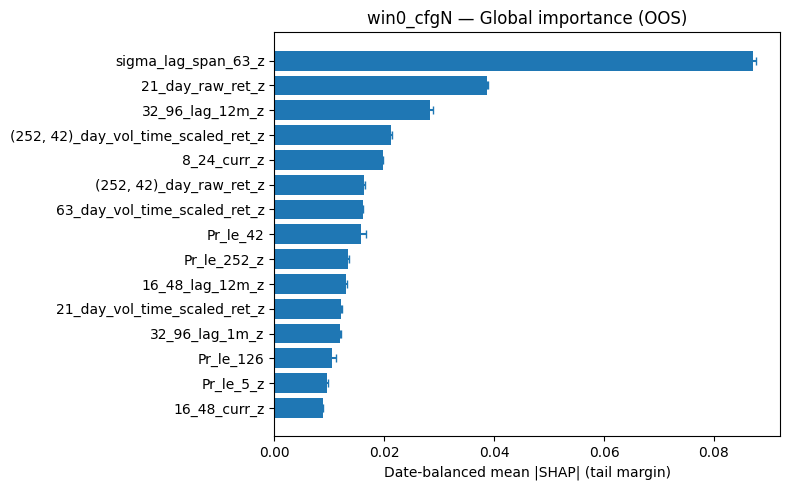

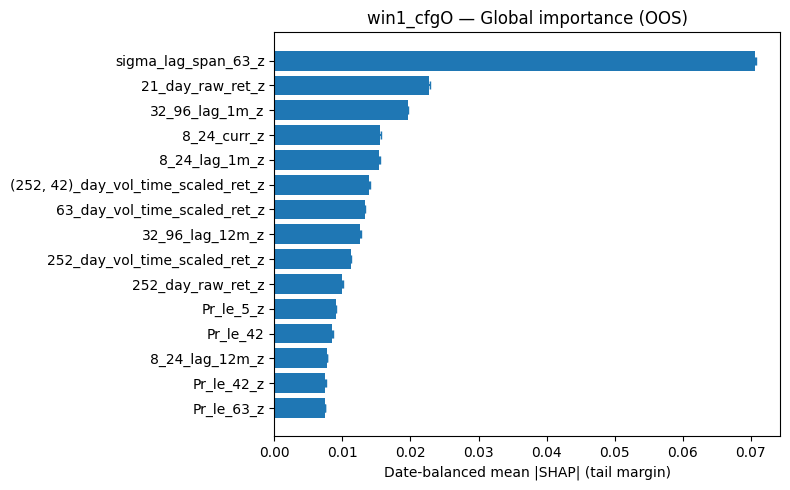

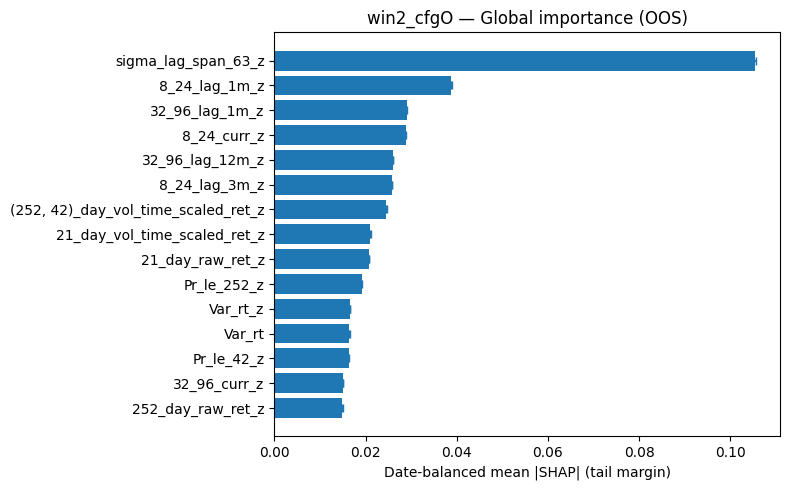

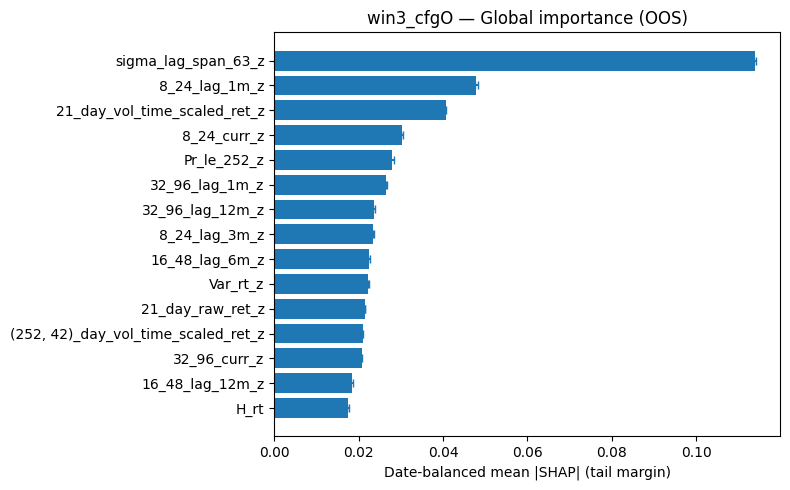

,feature,mean_abs_shap_margin,ci_lo_abs,ci_hi_abs,mean_signed_shap_margin,ci_lo_signed,ci_hi_signed,corr_vs_net,tail_high_minus_low,window
0,sigma_lag_span_63_z,0.087161,0.086706,0.087651,-0.017956,-0.018440,-0.017433,0.571100,0.232581,win0_cfgN
1,21_day_raw_ret_z,0.038718,0.038615,0.038825,-0.000865,-0.001055,-0.000693,0.507862,0.079378,win0_cfgN
2,32_96_lag_12m_z,0.028249,0.027730,0.028834,0.000198,0.000108,0.000285,0.300451,0.037776,win0_cfgN
3,"(252, 42)_day_vol_time_scaled_ret_z",0.021284,0.021093,0.021459,0.001006,0.000931,0.001081,0.219105,0.020366,win0_cfgN
4,8_24_curr_z,0.019741,0.019618,0.019855,0.000516,0.000420,0.000591,0.495546,0.044503,win0_cfgN
5,"(252, 42)_day_raw_ret_z",0.016292,0.016151,0.016435,0.003490,0.003321,0.003668,0.181488,0.012658,win0_cfgN
6,63_day_vol_time_scaled_ret_z,0.016103,0.016009,0.016198,-0.001297,-0.001372,-0.001226,0.454758,0.041617,win0_cfgN
7,Pr_le_42,0.015706,0.014820,0.016749,0.007827,0.006878,0.008938,0.197172,0.013622,win0_cfgN
8,Pr_le_252_z,0.013386,0.013281,0.013499,-0.000356,-0.000694,-0.000007,0.265042,0.016000,win0_cfgN
9,16_48_lag_12m_z,0.013013,0.012758,0.013301,-0.000002,-0.000032,0.000033,0.265854,0.017052,win0_cfgN


In [ ]:
SHOW_INLINE = True   # display figures inline
SAVE_FIGS   = True   # also save into shap_results_bocd/<win_label>/

import matplotlib.pyplot as plt

perwin_tables = {}
for lbl, art in ART.items():
    out_dir = art["out_dir"]
    if art["shap_df"] is not None:
        df = art["shap_df"]
    else:
        # Fallback: compute from arrays we loaded
        dates, phi, proba = art["dates"], art["phi"], art["proba"]
        net, _ = net_score_from_proba(proba)
        Tcodes, per_abs, per_sig = date_balanced_means(phi, dates)
        mean_abs, mean_sig = per_abs.mean(0), per_sig.mean(0)
        ci_abs = bootstrap_date_balanced(per_abs, B=300)
        ci_sig = bootstrap_date_balanced(per_sig, B=300)
        hi, lo, diff = tail_subset_means(phi, dates, net, q=0.10)
        df = pd.DataFrame({
            "feature": FEATURE_COLS,
            "mean_abs_shap_margin": mean_abs,
            "ci_lo_abs": ci_abs[:,0], "ci_hi_abs": ci_abs[:,1],
            "mean_signed_shap_margin": mean_sig,
            "ci_lo_signed": ci_sig[:,0], "ci_hi_signed": ci_sig[:,1],
            "tail_high_minus_low": diff,
        }).sort_values("mean_abs_shap_margin", ascending=False).reset_index(drop=True)
        df.to_csv(out_dir / f"{lbl}_shap_summary_rebuilt.csv", index=False)

    perwin_tables[lbl] = df
    plot_global_importance(df, f"{lbl} — Global importance (OOS)", out_png=out_dir / f"{lbl}_global_importance_viz.png")

# Combined CSV across windows
combined_global = pd.concat(
    [df.assign(window=lbl) for lbl, df in perwin_tables.items()],
    ignore_index=True
)
combined_global.to_csv(RESULTS / "global_importance_all_windows.csv", index=False)
display(combined_global.head(10))


C:\Users\benja\AppData\Local\Temp\ipykernel_13476\664541800.py:85: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


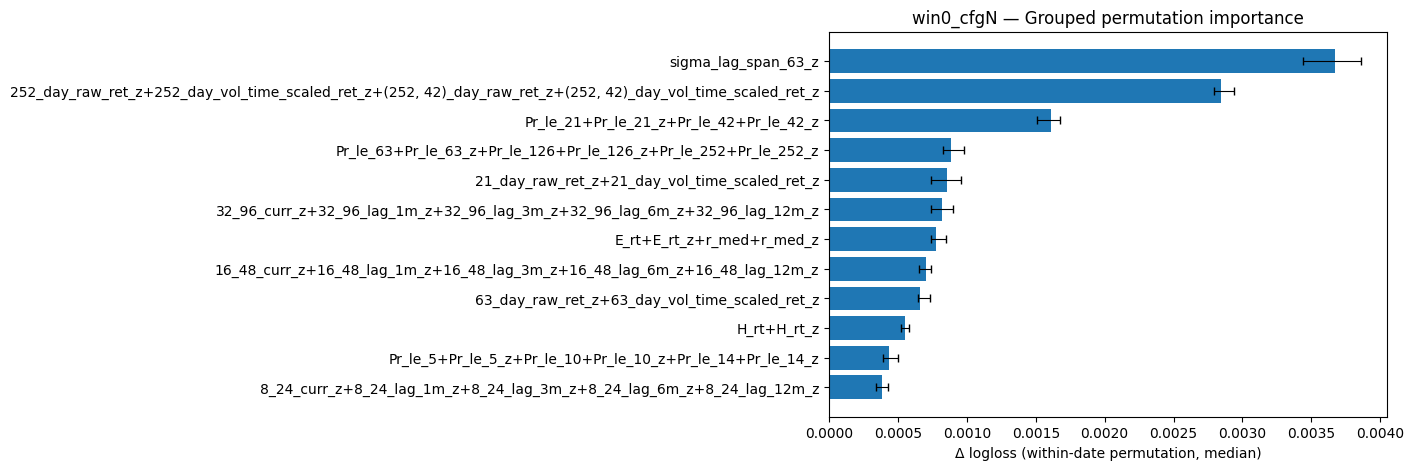

C:\Users\benja\AppData\Local\Temp\ipykernel_13476\664541800.py:85: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


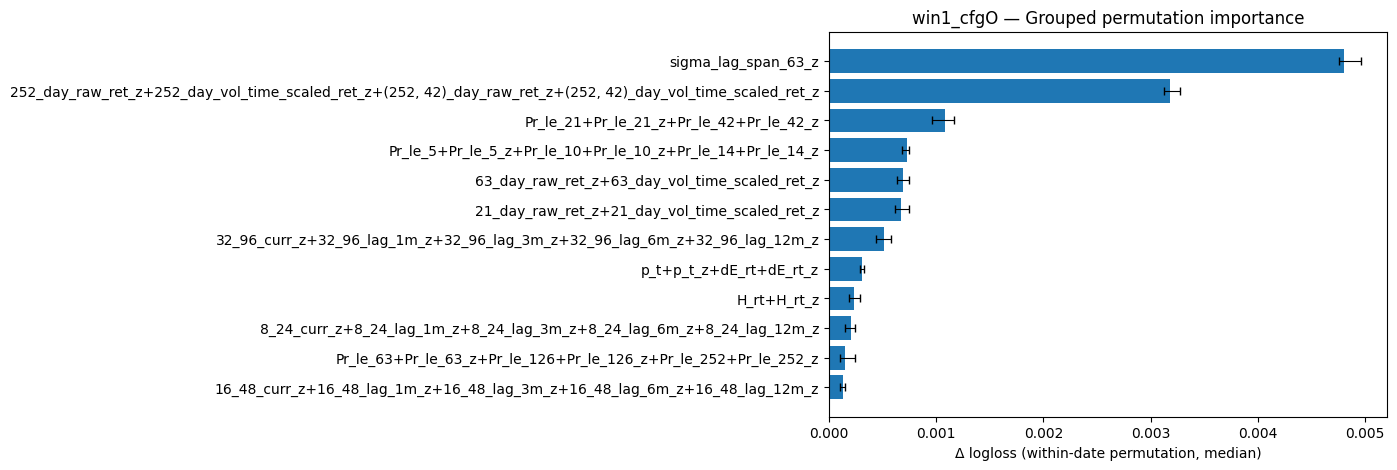

C:\Users\benja\AppData\Local\Temp\ipykernel_13476\664541800.py:85: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


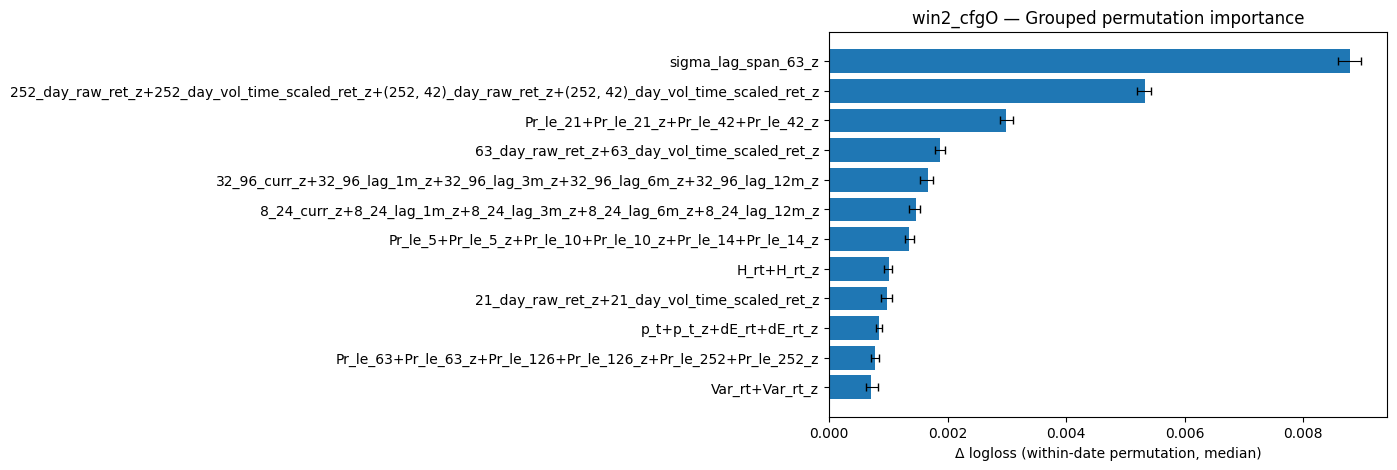

C:\Users\benja\AppData\Local\Temp\ipykernel_13476\664541800.py:85: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


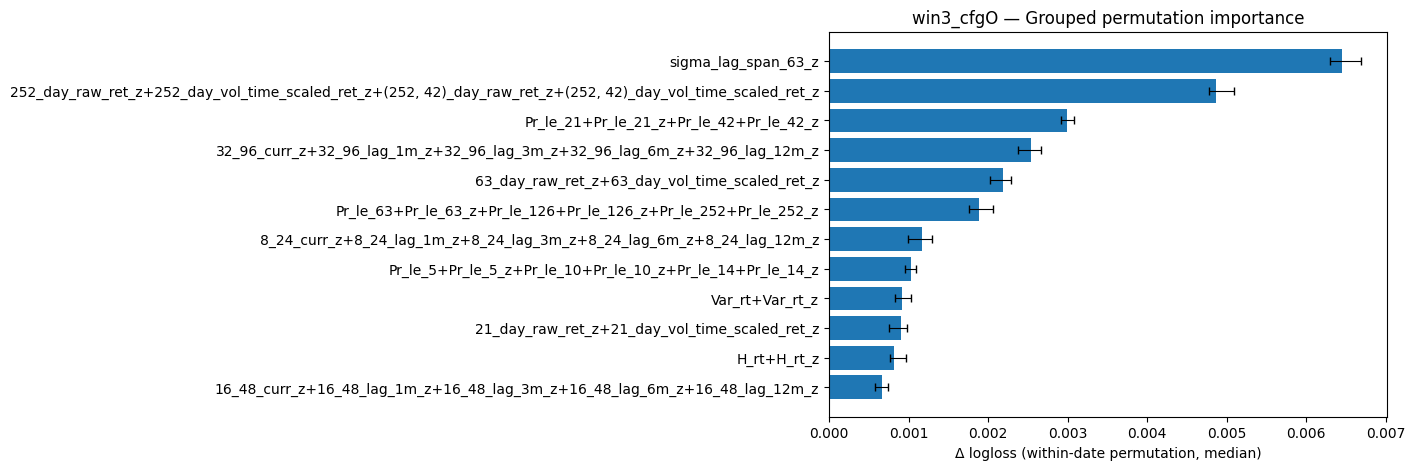

,window,feature,mean_abs_shap_margin,delta_logloss_share_med
0,win0_cfgN,sigma_lag_span_63_z,0.087161,0.003673
1,win0_cfgN,21_day_raw_ret_z,0.038718,0.000428
2,win0_cfgN,32_96_lag_12m_z,0.028249,0.000163
3,win0_cfgN,"(252, 42)_day_vol_time_scaled_ret_z",0.021284,0.000711
4,win0_cfgN,8_24_curr_z,0.019741,0.000076
5,win0_cfgN,"(252, 42)_day_raw_ret_z",0.016292,0.000711
6,win0_cfgN,63_day_vol_time_scaled_ret_z,0.016103,0.000331
7,win0_cfgN,Pr_le_42,0.015706,0.000403
8,win0_cfgN,Pr_le_252_z,0.013386,0.000147
9,win0_cfgN,16_48_lag_12m_z,0.013013,0.000141


In [ ]:
def _ensure_new_perm_schema(df: pd.DataFrame) -> pd.DataFrame:
    """
    Ensure we have the new columns:
      delta_logloss_med, delta_logloss_lo, delta_logloss_hi
    If it's a legacy file with only 'delta_logloss', create *_med and leave CI as NaN.
    """
    df = df.copy()
    if "delta_logloss_med" not in df.columns and "delta_logloss" in df.columns:
        df["delta_logloss_med"] = df["delta_logloss"]
        df["delta_logloss_lo"]  = np.nan
        df["delta_logloss_hi"]  = np.nan
        # optional legacy fill-ins for other metrics:
        for col in ["delta_rankIC_med","delta_rankIC_lo","delta_rankIC_hi",
                    "delta_TopBottom_med","delta_TopBottom_lo","delta_TopBottom_hi",
                    "n_perm"]:
            if col not in df.columns:
                df[col] = np.nan
    return df


def _split_group_string(g: str) -> list[str]:
    # groups are "f1+f2+..."; be robust to stray spaces
    return [s.strip() for s in str(g).split("+") if s.strip()]


def explode_group_delta_to_features(perm_df: pd.DataFrame) -> pd.DataFrame:
    """
    Split each group's delta_logloss (median and CI) equally across its member features.
    Then aggregate to the feature level (sum of shares).
    """
    perm_df = _ensure_new_perm_schema(perm_df)
    rows = []
    for _, r in perm_df.iterrows():
        members = _split_group_string(r["group"])
        k = max(len(members), 1)
        share_med = float(r["delta_logloss_med"]) / k
        share_lo  = (float(r["delta_logloss_lo"])  / k) if pd.notna(r["delta_logloss_lo"]) else np.nan
        share_hi  = (float(r["delta_logloss_hi"])  / k) if pd.notna(r["delta_logloss_hi"]) else np.nan
        for f in members:
            rows.append({
                "feature": f,
                "delta_logloss_share_med": share_med,
                "delta_logloss_share_lo":  share_lo,
                "delta_logloss_share_hi":  share_hi
            })
    out = (pd.DataFrame(rows)
           .groupby("feature", as_index=False)
           .agg({
               "delta_logloss_share_med": "sum",
               "delta_logloss_share_lo":  "sum",
               "delta_logloss_share_hi":  "sum"
           }))
    return out


all_scatter_rows = []

for lbl, art in ART.items():
    perm = art["perm_df"]
    if perm is None or perm.empty:
        print(f"{lbl}: permutation CSV not found — skipping.")
        continue

    perm = _ensure_new_perm_schema(perm)

    # Group bar (median delta_logloss with CI whiskers) + CSV 
    # Top 12 by median delta_logloss
    show = perm.sort_values("delta_logloss_med", ascending=True).tail(12).copy()

    fig, ax = plt.subplots(figsize=(7.2, 5))
    ax.barh(show["group"], show["delta_logloss_med"], label="median delta_logloss")

    # error bars: use asymm xerr if CI present
    if show[["delta_logloss_lo","delta_logloss_hi"]].notna().all().all():
        xerr = np.vstack([
            show["delta_logloss_med"].values - show["delta_logloss_lo"].values,
            show["delta_logloss_hi"].values - show["delta_logloss_med"].values
        ])
        ax.errorbar(show["delta_logloss_med"], np.arange(len(show)),
                    xerr=xerr, fmt="none", capsize=3, ecolor="k", lw=0.8)

    ax.set_xlabel("delta_ logloss (within-date permutation, median)")
    ax.set_title(f"{lbl} — Grouped permutation importance")
    plt.tight_layout()
    if SAVE_FIGS: plt.savefig(art["out_dir"]/f"{lbl}_perm_groups.png")
    if SHOW_INLINE: plt.show()
    plt.close(fig)

    perm.to_csv(art["out_dir"]/f"{lbl}_perm_groups.csv", index=False)

    shap_df = perwin_tables[lbl]  # contains 'feature' and 'mean_abs_shap_margin', etc.
    expl = explode_group_delta_to_features(perm)

    merged = shap_df.merge(expl, on="feature", how="inner").copy()
    merged["window"] = lbl

    all_scatter_rows.append(
        merged[["window", "feature", "mean_abs_shap_margin", "delta_logloss_share_med"]]
    )

    merged.to_csv(art["out_dir"]/f"{lbl}_shap_vs_perm_feature.csv", index=False)

#Combined scatter CSV (all windows)
if all_scatter_rows:
    all_scatter = pd.concat(all_scatter_rows, ignore_index=True)
    all_scatter.to_csv(RESULTS / "shap_vs_perm_feature_all_windows.csv", index=False)
    display(all_scatter.head(10))


In [ ]:
TOP_K = 15

#  Rank matrix for Kendall's W 
rank_mat = []
ranks_wide_rows = []
for lbl in WIN_LABELS:
    vec = (perwin_tables[lbl]
           .set_index("feature")
           .reindex(FEATURE_COLS)["mean_abs_shap_margin"]
           .to_numpy())
    rnk = rankdata(-vec, method="average")   # rank descending by importance
    rank_mat.append(rnk)
    ranks_wide_rows.append(pd.DataFrame({"feature": FEATURE_COLS, lbl: rnk}))
rank_mat = np.vstack(rank_mat)

W_all = kendalls_w(rank_mat)
print(f"Kendall’s W across windows (all {len(FEATURE_COLS)} features): {W_all:.3f}")

# Selection frequency in Top-K
topk_sets = {lbl: set(perwin_tables[lbl].head(TOP_K)["feature"]) for lbl in WIN_LABELS}
sel_counts = {f: sum(f in s for s in topk_sets.values()) for f in FEATURE_COLS}
sel_freq = (pd.DataFrame({"feature": FEATURE_COLS,
                          "selection_frequency": [sel_counts[f] for f in FEATURE_COLS]})
            .sort_values("selection_frequency", ascending=False, kind="mergesort")
            .reset_index(drop=True))
display(sel_freq.head(20))

# Pairwise rank correlations (Spearman)
rows = []
for i, a in enumerate(WIN_LABELS):
    for j, b in enumerate(WIN_LABELS):
        if j <= i: continue
        va = (perwin_tables[a].set_index("feature").reindex(FEATURE_COLS)["mean_abs_shap_margin"])
        vb = (perwin_tables[b].set_index("feature").reindex(FEATURE_COLS)["mean_abs_shap_margin"])
        rho, _ = spearmanr(va.rank(ascending=False), vb.rank(ascending=False))
        rows.append({"winA": a, "winB": b, "spearman_rho": rho})
pairwise = pd.DataFrame(rows).sort_values("spearman_rho", ascending=False)
display(pairwise.style.format({"spearman_rho": "{:.3f}"}))

# CSV saves 
sel_freq.to_csv(RESULTS / "stability_selection_frequency_topK.csv", index=False)
pd.DataFrame({"metric": ["kendalls_W_all_features"], "value": [W_all]}).to_csv(
    RESULTS / "stability_kendalls_W.csv", index=False
)
ranks_wide = ranks_wide_rows[0]
for k in range(1, len(ranks_wide_rows)):
    ranks_wide = ranks_wide.merge(ranks_wide_rows[k], on="feature", how="inner")
ranks_wide.to_csv(RESULTS / "stability_feature_ranks_by_window.csv", index=False)
pairwise.to_csv(RESULTS / "stability_pairwise_rank_corr.csv", index=False)


Kendall’s W across windows (all 52 features): 0.782


,feature,selection_frequency
0,sigma_lag_span_63_z,4
1,21_day_raw_ret_z,4
2,"(252, 42)_day_vol_time_scaled_ret_z",4
3,8_24_curr_z,4
4,32_96_lag_1m_z,4
5,32_96_lag_12m_z,4
6,21_day_vol_time_scaled_ret_z,3
7,8_24_lag_1m_z,3
8,Pr_le_252_z,3
9,252_day_raw_ret_z,2


,winA,winB,spearman_rho
5,win2_cfgO,win3_cfgO,0.900
3,win1_cfgO,win2_cfgO,0.822
4,win1_cfgO,win3_cfgO,0.744
0,win0_cfgN,win1_cfgO,0.683
1,win0_cfgN,win2_cfgO,0.607
2,win0_cfgN,win3_cfgO,0.497


,window,feature,mean_signed_shap,ci_lo,ci_hi
0,win0_cfgN,sigma_lag_span_63_z,-0.017956,-0.018440,-0.017433
1,win0_cfgN,21_day_raw_ret_z,-0.000865,-0.001055,-0.000693
2,win0_cfgN,63_day_raw_ret_z,0.000882,0.000825,0.000944
3,win0_cfgN,252_day_raw_ret_z,0.003312,0.003273,0.003353
4,win0_cfgN,21_day_vol_time_scaled_ret_z,-0.000859,-0.000892,-0.000828
5,win0_cfgN,63_day_vol_time_scaled_ret_z,-0.001297,-0.001372,-0.001226
6,win0_cfgN,252_day_vol_time_scaled_ret_z,0.001458,0.001418,0.001494
7,win0_cfgN,"(252, 42)_day_raw_ret_z",0.003490,0.003321,0.003668
8,win0_cfgN,"(252, 42)_day_vol_time_scaled_ret_z",0.001006,0.000931,0.001081
9,win0_cfgN,8_24_curr_z,0.000516,0.000420,0.000591


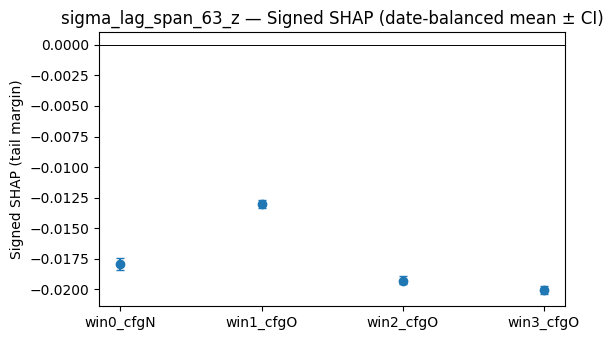

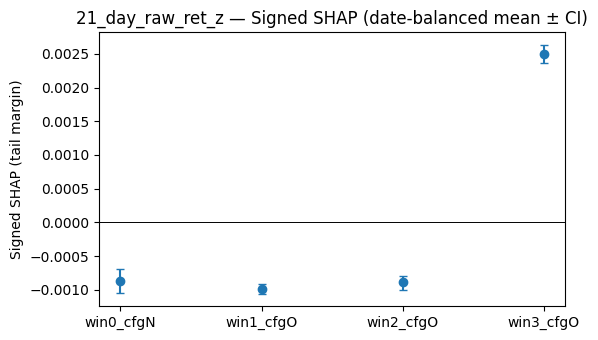

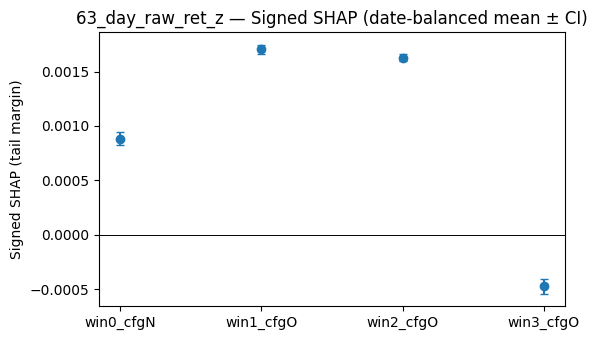

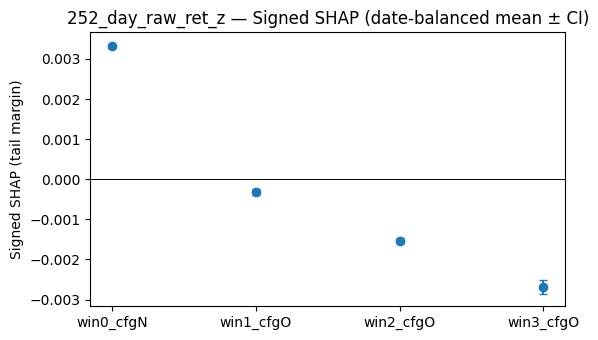

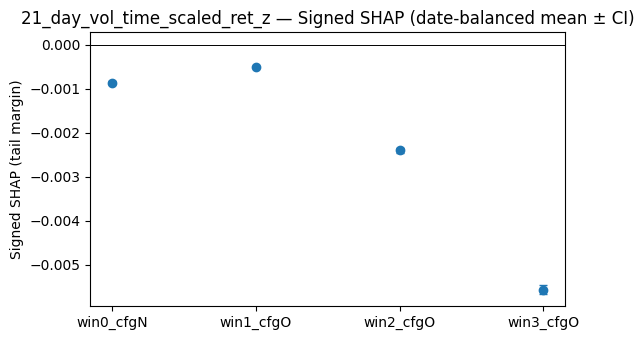

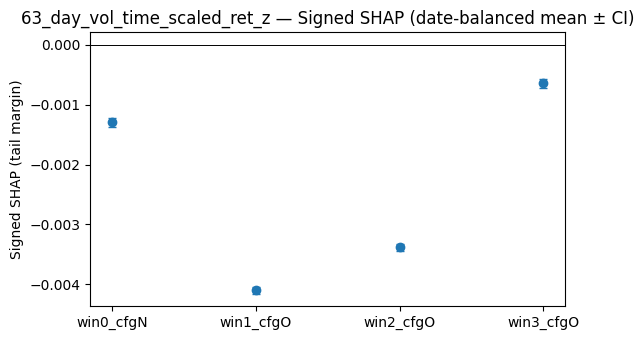

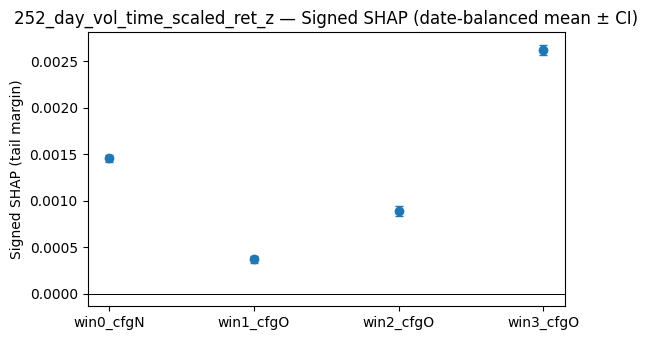

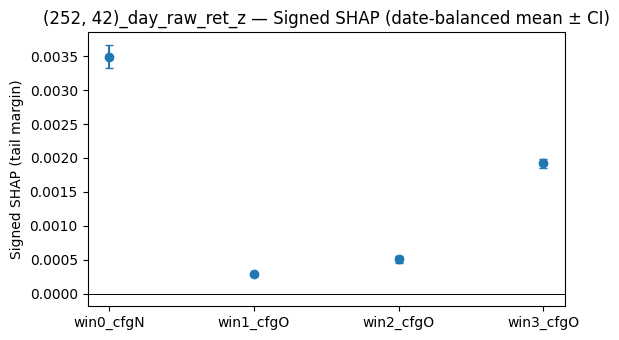

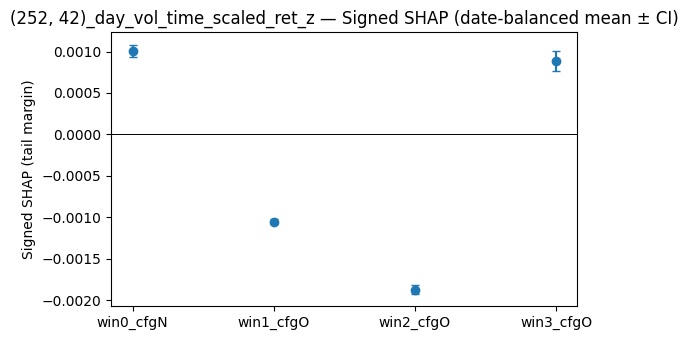

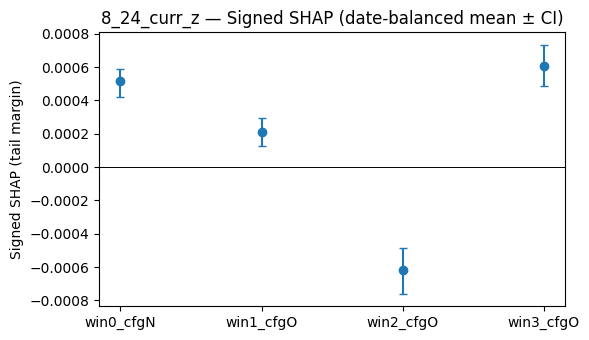

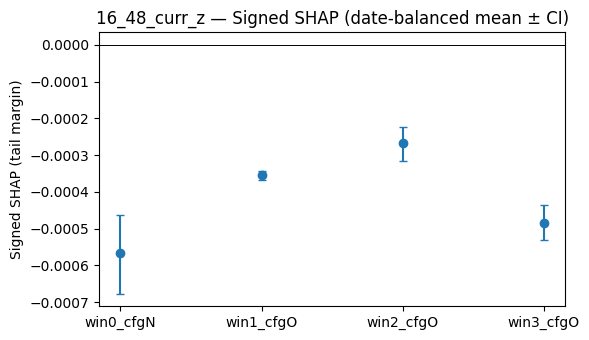

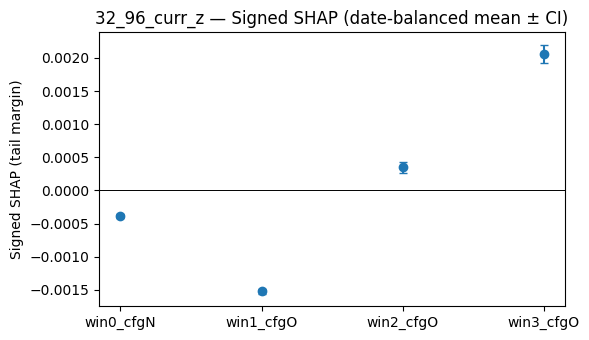

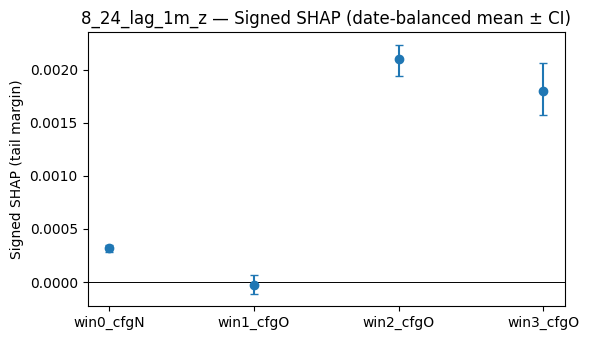

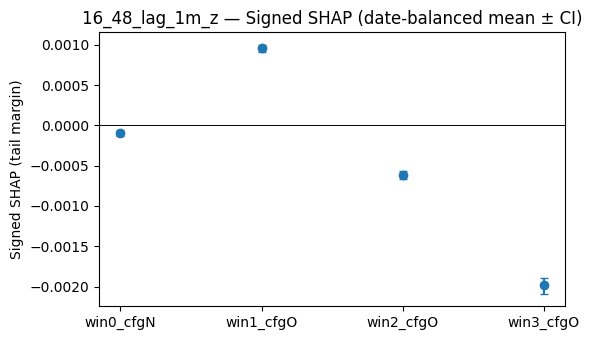

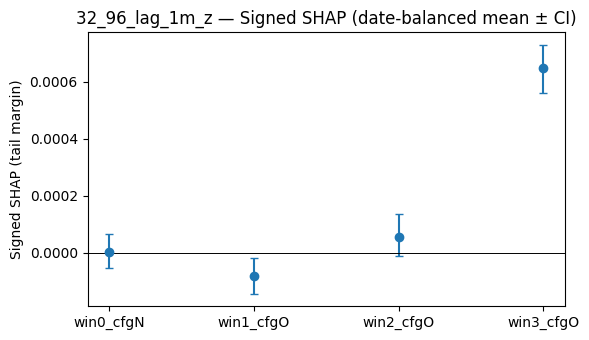

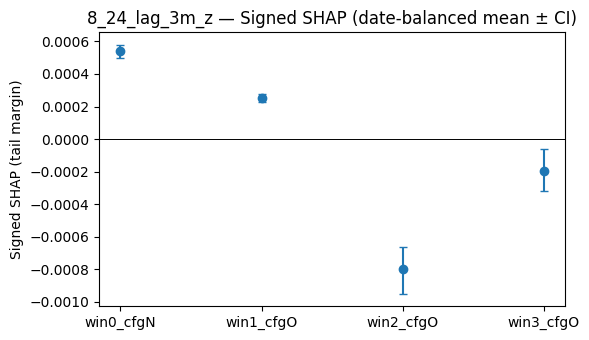

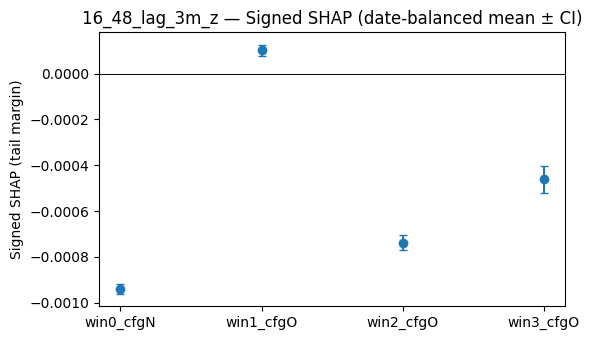

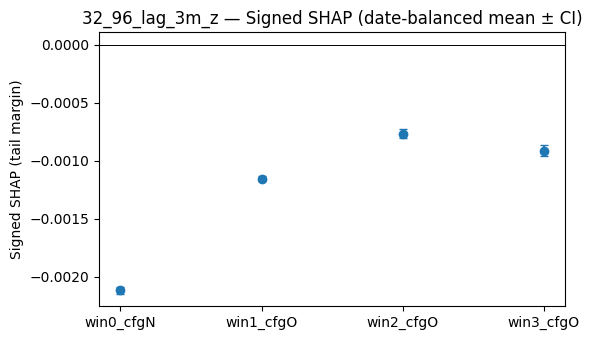

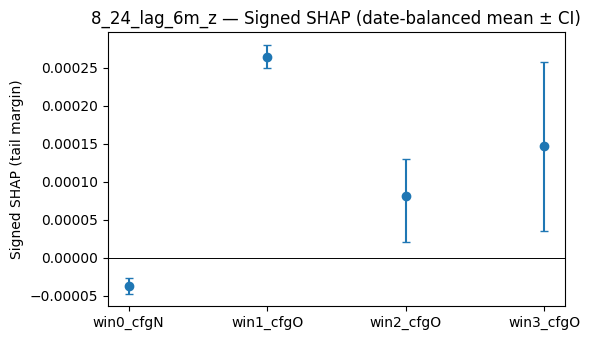

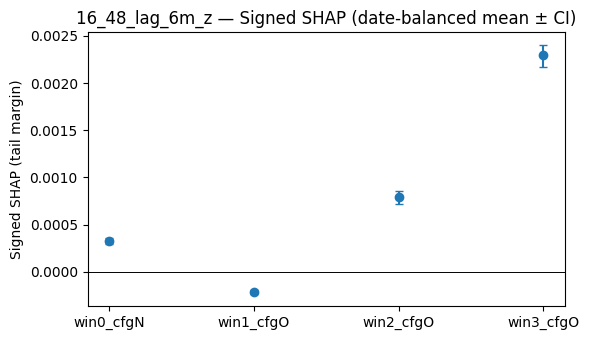

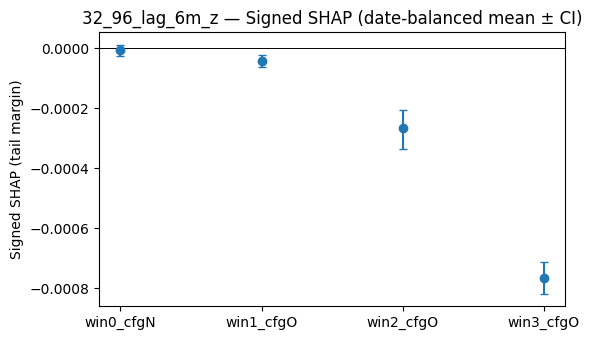

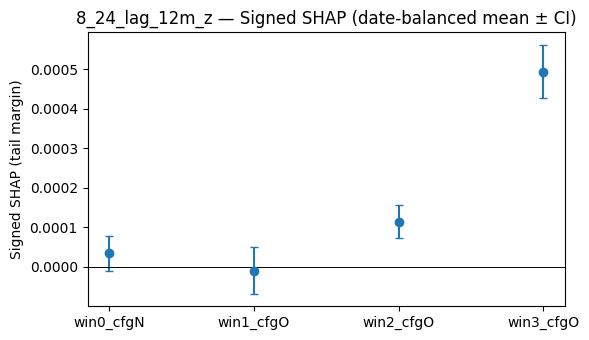

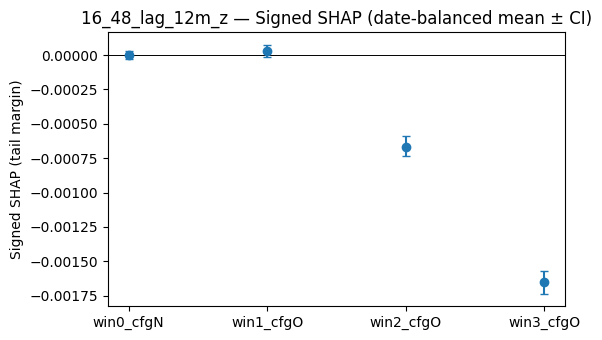

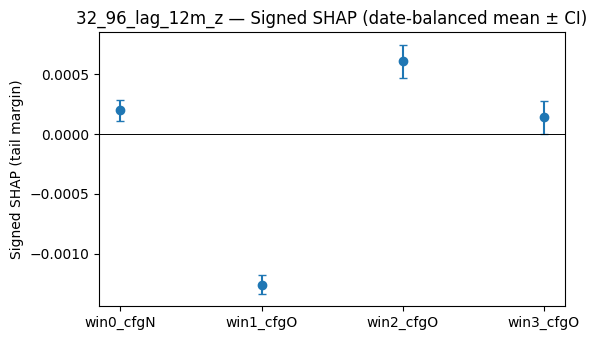

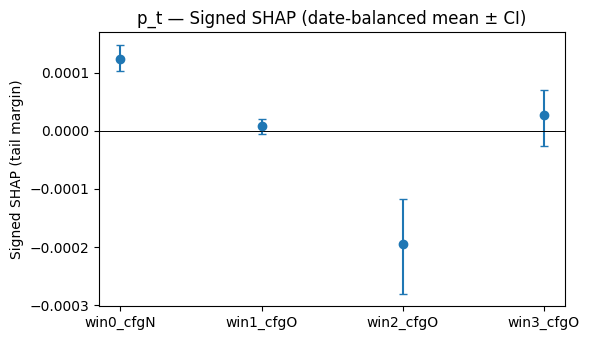

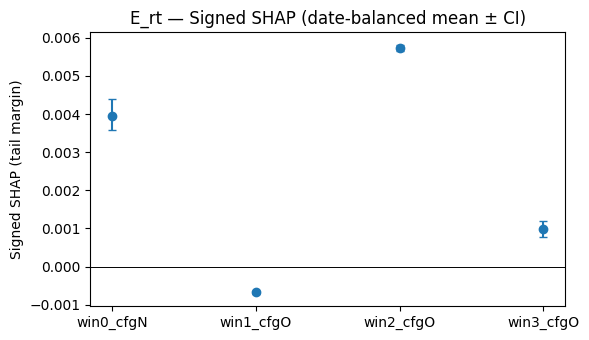

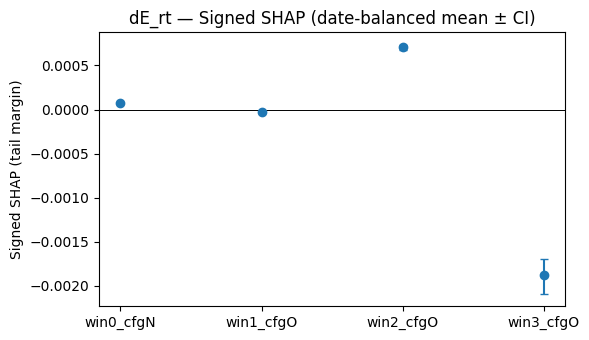

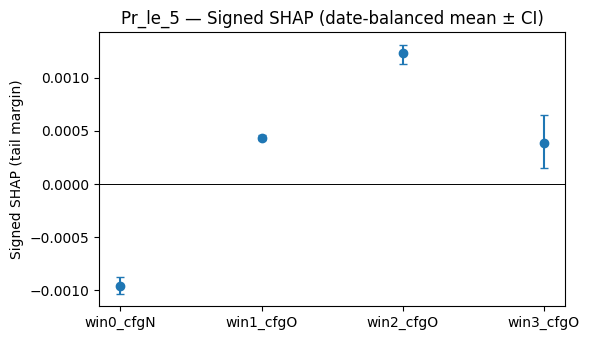

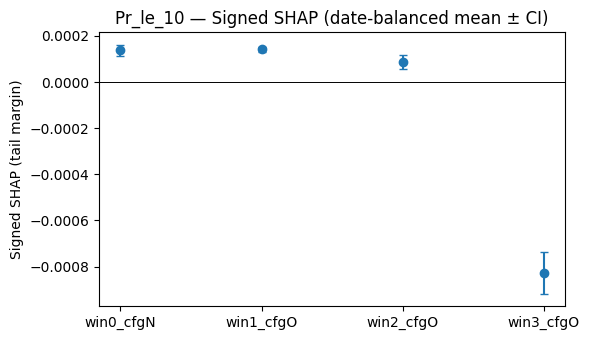

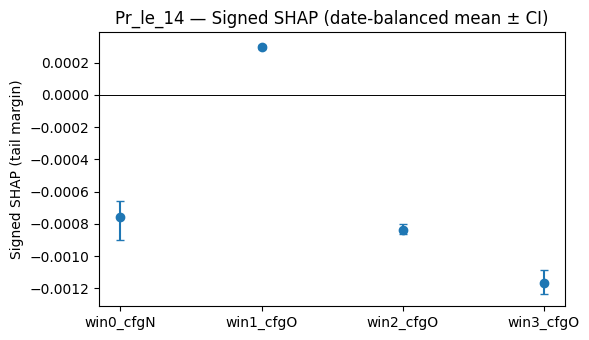

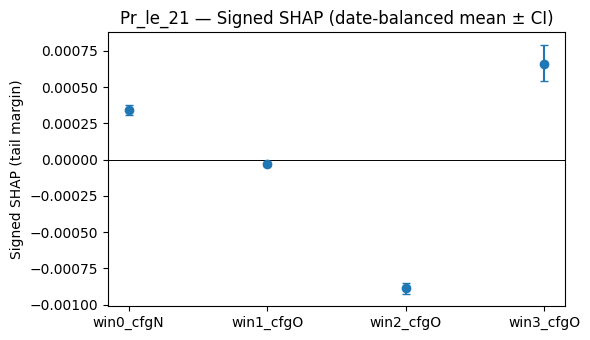

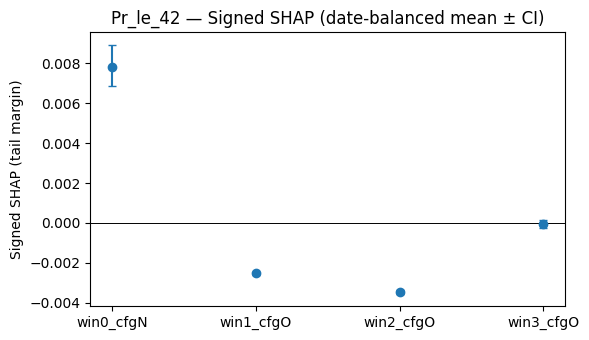

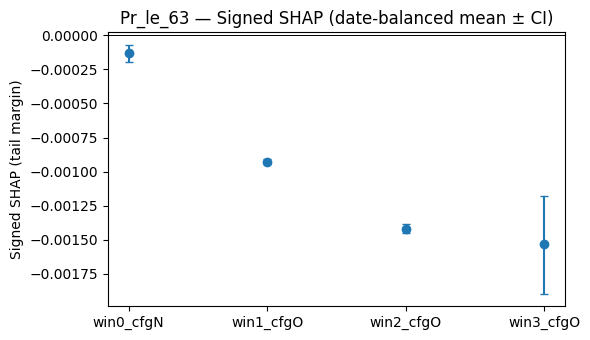

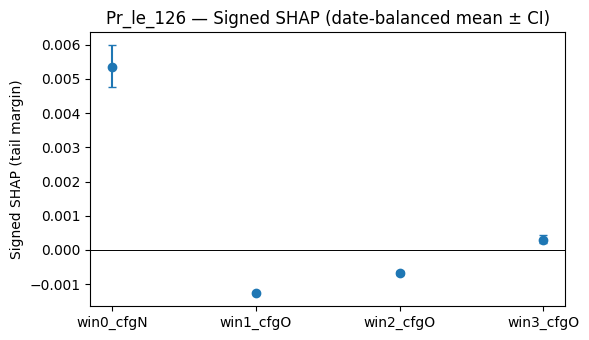

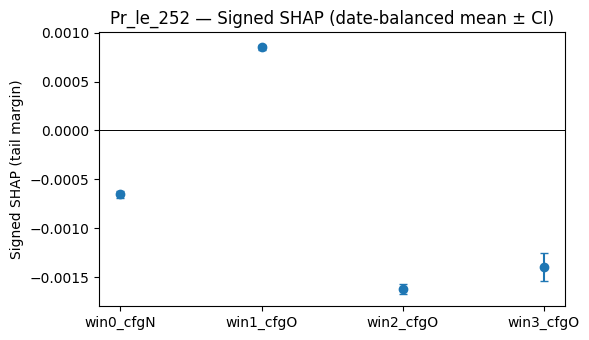

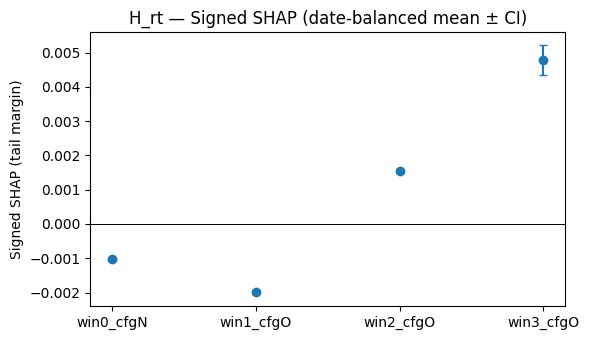

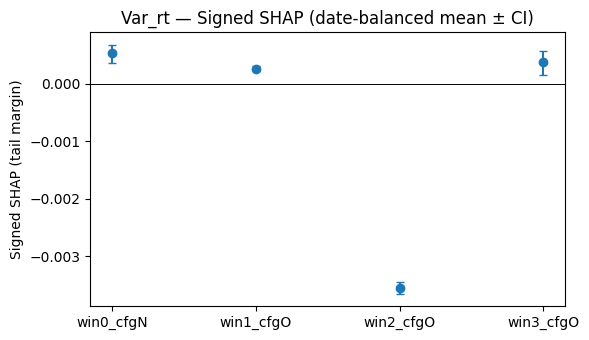

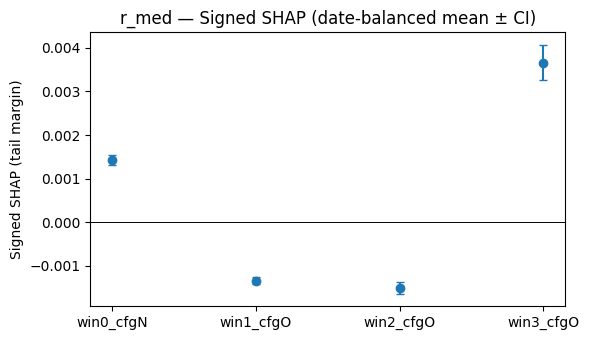

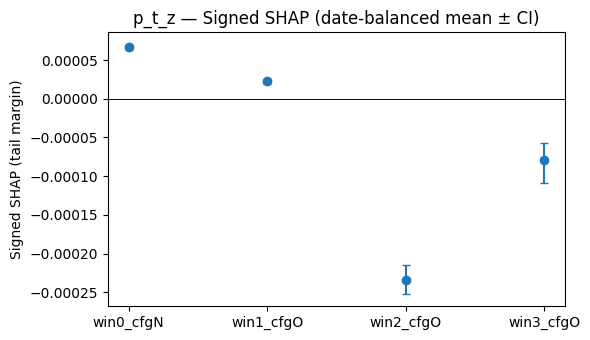

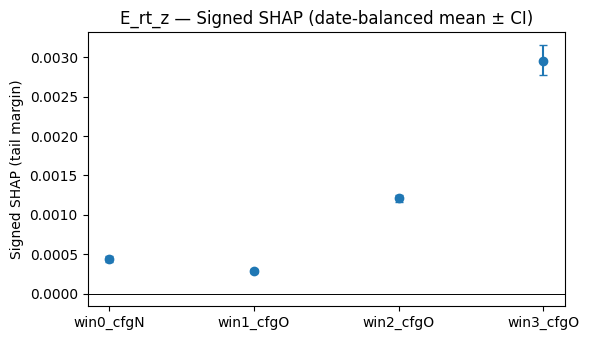

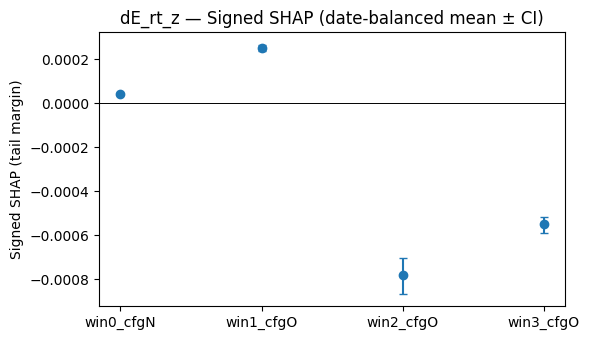

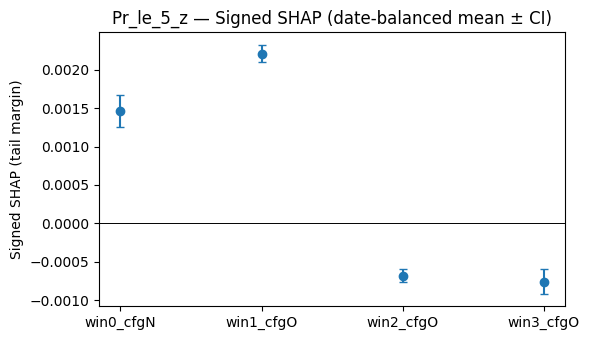

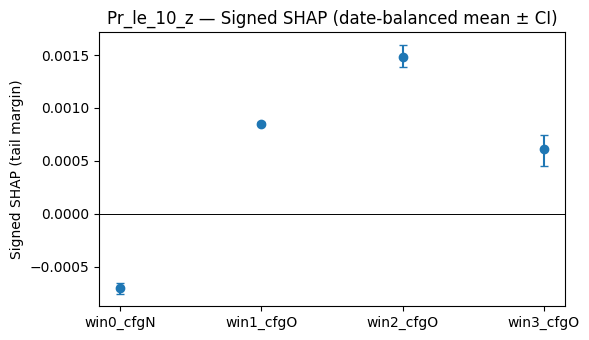

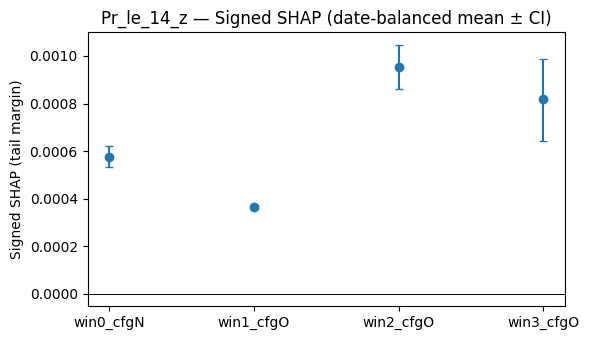

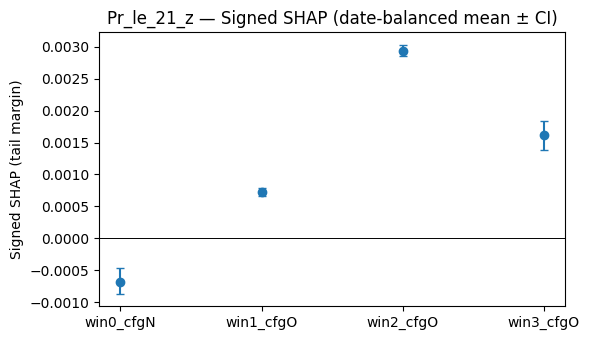

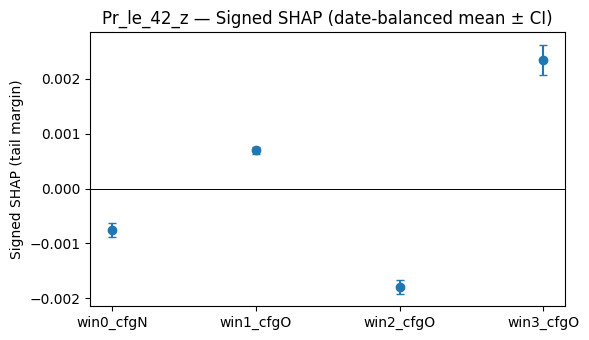

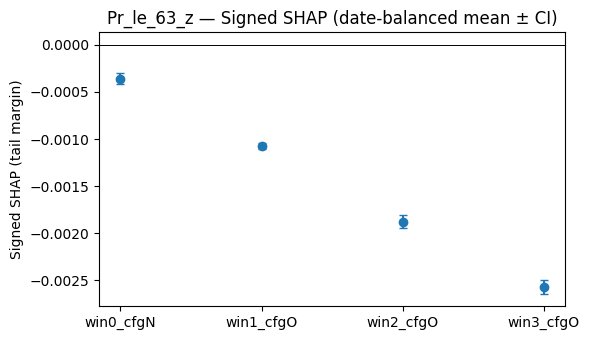

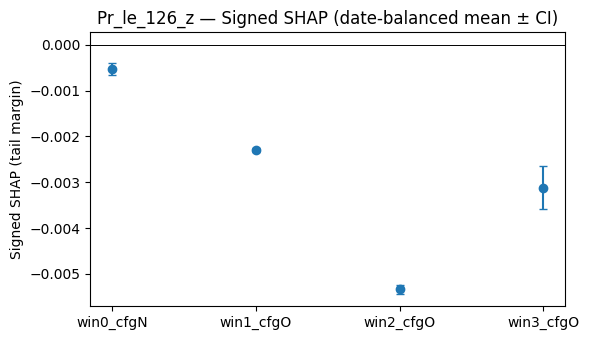

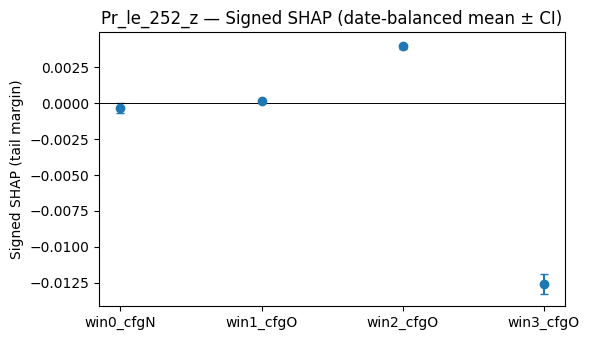

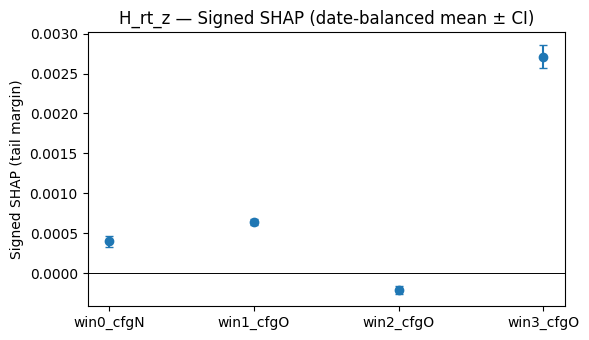

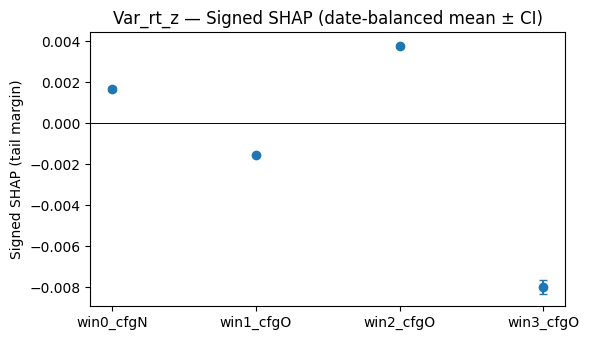

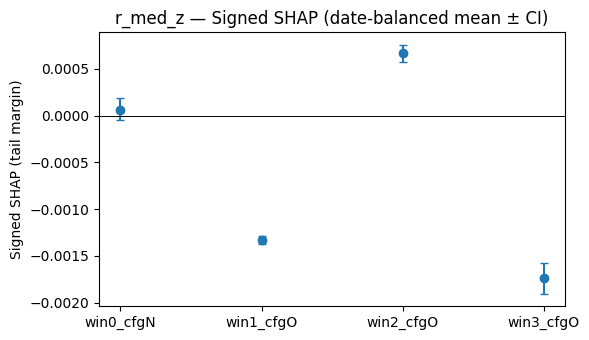

In [ ]:
KEY_FEATURES = FEATURE_COLS

# Signed SHAP summary (with CIs) across windows
rows = []
for lbl in WIN_LABELS:
    t = perwin_tables[lbl].set_index("feature")
    for f in KEY_FEATURES:
        if f not in t.index: continue
        rows.append({
            "window": lbl, "feature": f,
            "mean_signed_shap": t.loc[f,"mean_signed_shap_margin"],
            "ci_lo": t.loc[f,"ci_lo_signed"],
            "ci_hi": t.loc[f,"ci_hi_signed"],
        })
signed_tbl = pd.DataFrame(rows)
display(signed_tbl.head(20))
signed_tbl.to_csv(RESULTS / "direction_signed_shap_key_features.csv", index=False)

# Plot per feature across windows
for f in KEY_FEATURES:
    d = signed_tbl[signed_tbl["feature"]==f]
    if d.empty: continue
    fig, ax = plt.subplots(figsize=(6,3.5))
    ax.errorbar(d["window"], d["mean_signed_shap"],
                yerr=[d["mean_signed_shap"]-d["ci_lo"], d["ci_hi"]-d["mean_signed_shap"]],
                fmt="o", capsize=3)
    ax.axhline(0, color="k", lw=0.7)
    ax.set_title(f"{f} — Signed SHAP (date-balanced mean ± CI)")
    ax.set_ylabel("Signed SHAP (tail margin)")
    plt.tight_layout()
    if SAVE_FIGS: plt.savefig(RESULTS/f"{f}_signed_shap_by_window.png")
    if SHOW_INLINE: plt.show()
    plt.close(fig)

# Tail-subset view: mean SHAP contributions in Long/Short deciles
all_tail_rows = []
for lbl, art in ART.items():
    P, phi, dates = art["proba"], art["phi"], art["dates"]
    net, _ = net_score_from_proba(P)
    hi, lo, diff = tail_subset_means(phi, dates, net, q=0.10)
    tab = (pd.DataFrame({"feature": FEATURE_COLS, "LongDecile": hi, "ShortDecile": lo, "HighMinusLow": diff})
           .sort_values("HighMinusLow", ascending=False))
    tab.to_csv(art["out_dir"]/f"{lbl}_tail_subset_view.csv", index=False)
    tab2 = tab.copy(); tab2.insert(0, "window", lbl)
    all_tail_rows.append(tab2)

# Combined tail-subset CSV
if all_tail_rows:
    pd.concat(all_tail_rows, ignore_index=True).to_csv(RESULTS / "tail_subset_view_all_windows.csv", index=False)
